# SMS SPAM DETECTION WITH TENSORFLOW.

IMPORTATION OF THE lIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow  as tf
from tensorflow import keras
from tensorflow.keras import layers

### Loading dataset .read_csv()

In [12]:
# Using this to load the file from my External Hard drive AND Saving it to Uploaded
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam (2).csv


In [16]:
# when we load the data we use .dropna(axis=1) to drop the unamed columns with null values.
import io
# I will use this io.BytesIO(uploaded['spam (2).csv']) to read the csv file from the io that i uploaded the file.
df = pd.read_csv(io.BytesIO(uploaded['spam (2).csv']),encoding = 'latin-1').dropna(axis = 1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


i will rename the columns v1 and v2 to label and Text respectively

since the target variable is in string form I will encode it numerically using pandas function .map()

In [17]:
df =  df.rename(columns = {'v1': 'label',
                           'v2' : 'Text'})

df['label_enc'] = df['label'].map({'ham': 0,
                                   'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### LETS VISUALIZE THE DISTRIBUTION OF HAM AND SPAM DATA

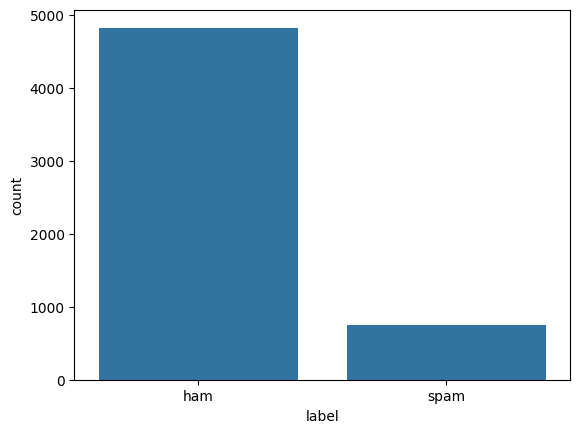

In [18]:
sns.countplot(x=df['label'])
plt.show()

## NB
we can see that Ham data is comapratively higher than spam data, this is natural, since I will be using embeddings in our deep learning model, I do not have to balance the data. Now lets find the average number of words in all sentences in SMS data

In [19]:
# Average number of tokens in all sentences
avg_words_len = round(sum([len(i.split()) for i in df['Text']]) / len(df['Text']))

print (avg_words_len)

15


### Now lets find the Total number of unique words in Corpus


In [20]:
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)

total_words_length = len(s)
print(f"Total Words Length: {total_words_length}")

Total Words Length: 15585


## SPLIT DATA INTO TRAINING AND TESTING PARTS

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score

X, y = np.asanyarray(df['Text']),  np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label' : y})

X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'],
                                                    test_size = 0.2, random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

# Building The Model
first I will build a baseline model and then try to beat the performance of the baseline using deep learning models *(embeddings, LSTM and others)*

I will use **MultinomialNB()**, this performs very well for text Classififcation when featurs are dicrete like word counts of the words or **tf-idf vectors** (this is a measure that tells us how important or relevant a word is in the document)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [23]:
tfidf_vec = TfidfVectorizer().fit(X_train)

X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)


baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec, y_train)

MultinomialNB()

## Performance  of baseline model

Accuracy on Train Data: 97.28516939645502
Accuracy on Test Data : 96.23318385650225


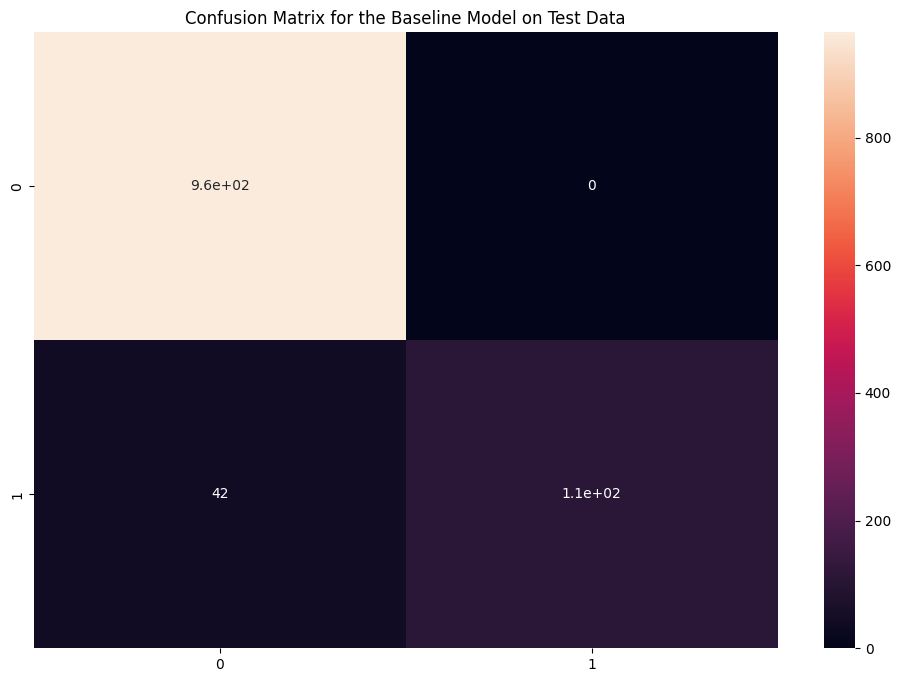

In [24]:
preds = baseline_model.predict(X_test_vec)

#using the K-fold for cross validation

def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))


print(f"Accuracy on Train Data: {accuracy_score(y_train, baseline_model.predict(X_train_vec))*100}")

print(f"Accuracy on Test Data : {accuracy_score(y_test, preds)*100}")

# The Confusion Matrix

cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for the Baseline Model on Test Data")
plt.show()

## Model 1: Creating custom Text Vectoriation and embeding layers:

    - **Text vectorization** is turning text into numerical representation. example **Bag of words frequency, Binary Term frequency, etc**
    - **Word Embedding** this is a learned representation of text in which words with related meanings have similar representations. each word assigned a single vector, this vectores are learned by a neural Network.

### Custom Text Vectorization layer (**TensorFlow**)

In [25]:
from tensorflow.keras.layers import TextVectorization
MAXTOKENS = total_words_length
OUTPUTLEN = avg_words_len

text_vec = TextVectorization(max_tokens = MAXTOKENS,
                             standardize = 'lower_and_strip_punctuation',
                             output_mode = 'int',
                             output_sequence_length = OUTPUTLEN )

text_vec.adapt(X_train)



### Create an embedding layer

In [26]:
embedding_layer =layers.Embedding(input_dim = MAXTOKENS,
                                  output_dim = 128,
                                  embeddings_initializer = 'uniform',
                                  input_length = OUTPUTLEN )



input_dim is the size of vocabulary.
    
output_dim is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedde.



input_length is the length of input sequenc.es

### Now lets build and compile model 1 using tensorflow functional API

In [27]:
input_layer = layers.Input(shape= (1,), dtype = tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)
output_layer = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer = 'adam', loss= keras.losses.BinaryCrossentropy(label_smoothing = 0.5),
                                                                          metrics = ['accuracy'])


In [28]:
# The model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

## CallBack
lets check and controll the models performance


In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience = 6,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

## Training the model_1

In [30]:
history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs = 20,
                      batch_size = 32,
                      callbacks = [lr,es])

Epoch 1/20
140/140 [==============================] - 5s 29ms/step - loss: 0.6060 - accuracy: 0.9053 - val_loss: 0.5775 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 5s 34ms/step - loss: 0.5702 - accuracy: 0.9874 - val_loss: 0.5735 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 4s 27ms/step - loss: 0.5656 - accuracy: 0.9955 - val_loss: 0.5726 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 4s 26ms/step - loss: 0.5641 - accuracy: 0.9982 - val_loss: 0.5724 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 5s 32ms/step - loss: 0.5633 - accuracy: 0.9991 - val_loss: 0.5726 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 6/20
140/140 [==============================] - 4s 28ms/step - loss: 0.5630 - accuracy: 0.9998 - val_loss: 0.5726 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 7/20
140/140 [==============================] - 4s 28ms/st

### Ploting the models history

Train Accuracy:  100.0 %
Train Loss:  56.25426173210144 %


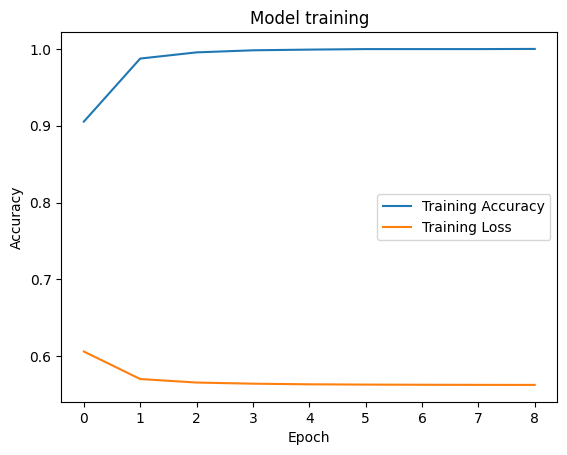

In [31]:
print('Train Accuracy: ', np.max(history.history['accuracy'] )*100, '%')
print('Train Loss: ', np.min(history.history['loss'])*100,'%')

plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['loss'],label = 'Training Loss')
plt.title('Model training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Helper function for compiling fitting and evaluating the model

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    # Simply compile the model with adam optimizer
    model.compile(optimizer = keras.optimizers.Adam(),
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics = ['accuracy'])

def fit_model(model, epochs, X_train = X_train, y_train = y_train,  X_test = X_test, y_test = y_test):
    # fi the model with the given epochs, training and test data
    history = model.fit(X_train,
                        y_train,
                        epochs = epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)),
                       callbacks = [lr,es])
    print('Train Accuracy: ', np.max(history.history['accuracy'] )*100, '%')
    print('Train Loss: ', np.min(history.history['loss'])*100,'%')

    plt.plot(history.history['accuracy'],label = 'Training Accuracy')
    plt.plot(history.history['loss'],label = 'Training Loss')
    plt.plot(history.history['val_accuracy'], label = 'validation Accuracy')
    plt.plot(history.history['val_loss'],label = 'validation Loss')
    plt.title('Model training')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return history

def evaluate_model(model, X,y):
    # evaluate the model and return accuracy, precision, recall and f1-score

    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    print("Model Performance in percentage (%)")
    model_results_dict = {'accuracy': accuracy * 100,
                          'precision': precision * 100,
                          'recall': recall * 100,
                          'f1-score': f1 * 100}


    return model_results_dict

### Model_2 Bidirectional LSTM
this will effectively improve the networkd accesible information, boosting the context for the algorithm.

Epoch 1/20
140/140 [==============================] - 20s 88ms/step - loss: 0.0584 - accuracy: 0.9818 - val_loss: 0.1034 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 11s 76ms/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 0.0766 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 11s 78ms/step - loss: 2.3725e-04 - accuracy: 1.0000 - val_loss: 0.1202 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 13s 90ms/step - loss: 2.9430e-05 - accuracy: 1.0000 - val_loss: 0.1282 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 11s 75ms/step - loss: 1.6673e-05 - accuracy: 1.0000 - val_loss: 0.1306 - val_accuracy: 0.9839 - lr: 5.0000e-04
Epoch 6/20
140/140 [==============================] - 11s 77ms/step - loss: 1.4300e-05 - accuracy: 1.0000 - val_loss: 0.1327 - val_accuracy: 0.9839 - lr: 5.0000e-04
Epoch 7/20
140/140 [==============

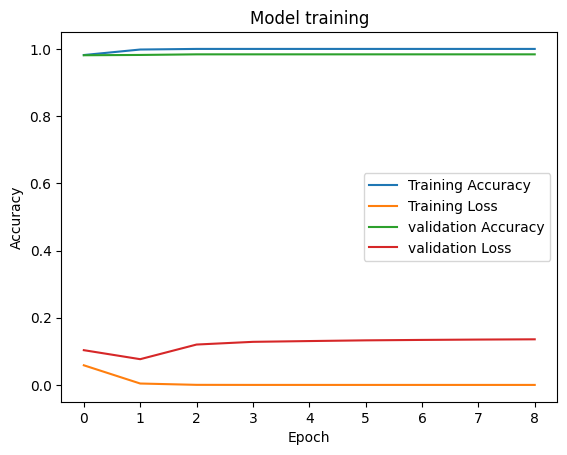

In [33]:
input_layer = layers.Input(shape = (1,), dtype = tf.string)
vec_layer = text_vec(input_layer)

embedding_layer_model = embedding_layer(vec_layer)

bi_lstm = layers.Bidirectional(layers.LSTM(64,
                                           activation ='tanh',
                                           return_sequences =True))(embedding_layer_model)

lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)

x = layers.Dense(32, activation = 'relu')(dropout)
output_layer = layers.Dense(1, activation ='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # Compile the model
history_2 = fit_model(model_2, epochs = 20) # fit the model

### MODEL_2 EVALUATION

In [34]:
evaluate_model(model_2,X_test,y_test)

35/35 [==============================] - 2s 19ms/step
Model Performance in percentage (%)


{'accuracy': 98.38565022421525,
 'precision': 97.82608695652173,
 'recall': 90.0,
 'f1-score': 93.75}

### Model- 3 Transfer Learning with USE Encoder
**Transfer learning** is an approch where one model generated for one job is utilized as the foundation for model on a different task.

**USE  Layer (universal Sentence Encoder)** this converts text into high dimensional vectors that may be used for text categorization, semantic similarity and other language applications

The USE is from Tensorflow_hub  and can be used as a layer **.kerasLayer()**

In [36]:
import tensorflow_hub as hub

### Model_3 with Sequential api

In [37]:
model_3 = keras.Sequential()

### Universal-sentence-encoderlayer

Epoch 1/5
140/140 [==============================] - 10s 48ms/step - loss: 0.2772 - accuracy: 0.9215 - val_loss: 0.1075 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 2/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0779 - accuracy: 0.9778 - val_loss: 0.0689 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/5
140/140 [==============================] - 6s 46ms/step - loss: 0.0556 - accuracy: 0.9838 - val_loss: 0.0591 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 4/5
140/140 [==============================] - 4s 30ms/step - loss: 0.0465 - accuracy: 0.9863 - val_loss: 0.0539 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 5/5
140/140 [==============================] - 4s 30ms/step - loss: 0.0403 - accuracy: 0.9883 - val_loss: 0.0521 - val_accuracy: 0.9830 - lr: 0.0010
Train Accuracy:  98.8332986831665 %
Train Loss:  4.025813192129135 %


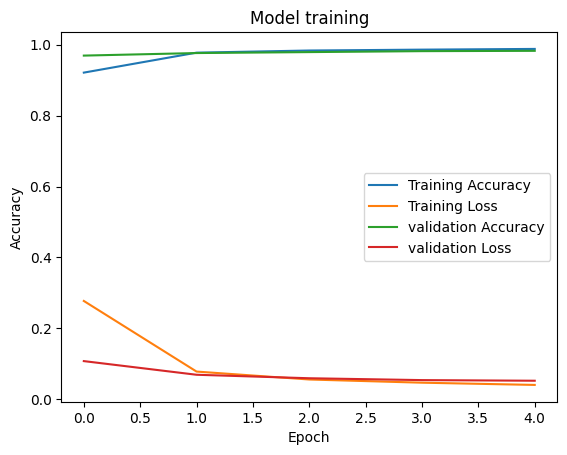

In [38]:
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable = False,
                           input_shape =[],
                           dtype = tf.string,
                           name ='USE')

model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation = keras.activations.relu))
model_3.add(layers.Dense(1, activation = keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs =5)

### Now evaluatig all the models

In [39]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1,X_test,y_test)
model_2_results = evaluate_model(model_2,X_test,y_test)
model_3_results = evaluate_model(model_3,X_test,y_test)

total_results = pd.DataFrame({'MultinomialNB Model' : baseline_model_results,
                              'Custom-Vec-Embedding Model': model_1_results,
                              'Bidirectional-LSTM Model':model_2_results,
                              'USE-Transfer Learning Model':model_3_results}).transpose()

total_results


Model Performance in percentage (%)
35/35 [==============================] - 0s 2ms/step
Model Performance in percentage (%)
35/35 [==============================] - 0s 11ms/step
Model Performance in percentage (%)
35/35 [==============================] - 1s 10ms/step
Model Performance in percentage (%)


,accuracy,precision,recall,f1-score
MultinomialNB Model,96.233184,100.000000,72.000000,83.720930
Custom-Vec-Embedding Model,98.116592,98.496241,87.333333,92.579505
Bidirectional-LSTM Model,98.385650,97.826087,90.000000,93.750000
USE-Transfer Learning Model,98.295964,97.122302,90.000000,93.425606


## Results
All for models deliver excelent results, Thus Comparing them might be difficult.
### Problem
I have an unbalanced dataset; most of my data points contain the label “ham,” which is natural because most SMS are ham. Accuracy cannot be an appropriate metric in certain situations.

project by Joseph Wathome